# MPEK (logkcat-logkm)

# Calculate the mean value of predicted log(kcat/km) of 5 folds on test dataset

In [1]:
import numpy as np
import os
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

def return_scores(y_test, y_pred):
    # 移除 NaN 值
    mask = ~np.isnan(y_test)
    y_test_filtered = y_test[mask]
    y_pred_filtered = y_pred[mask]

    # scores
    rmse = np.sqrt(mean_squared_error(y_test_filtered, y_pred_filtered))
    mae = mean_absolute_error(y_test_filtered, y_pred_filtered)
    r2 = r2_score(y_test_filtered, y_pred_filtered)
    pcc = pearsonr(y_test_filtered, y_pred_filtered)

    return rmse, mae, r2, pcc[0]

current_dir = os.getcwd()
test_pred_npy= np.load(f'{current_dir}/../base_split_kcatkm/results/mpek_test_pred.npy', allow_pickle=True)
test_pred_npy.shape
logkcat_pred_mean = test_pred_npy[:, 1, :].mean(axis=0)
test_label_npy= np.load(f'{current_dir}/../base_split_kcatkm/results/mpek_test_y.npy')
# test_label_npy.shape
logkcat_test_y = test_label_npy[:, 1, :].mean(axis=0)
logkcat_scores = return_scores(logkcat_test_y, logkcat_pred_mean)
logkcat_scores

(2.648590650282921,
 1.9913519058078677,
 0.45641720003618047,
 0.7118922007803621)

C:\Users\ching\AppData\Local\Temp\ipykernel_34584\1855326571.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


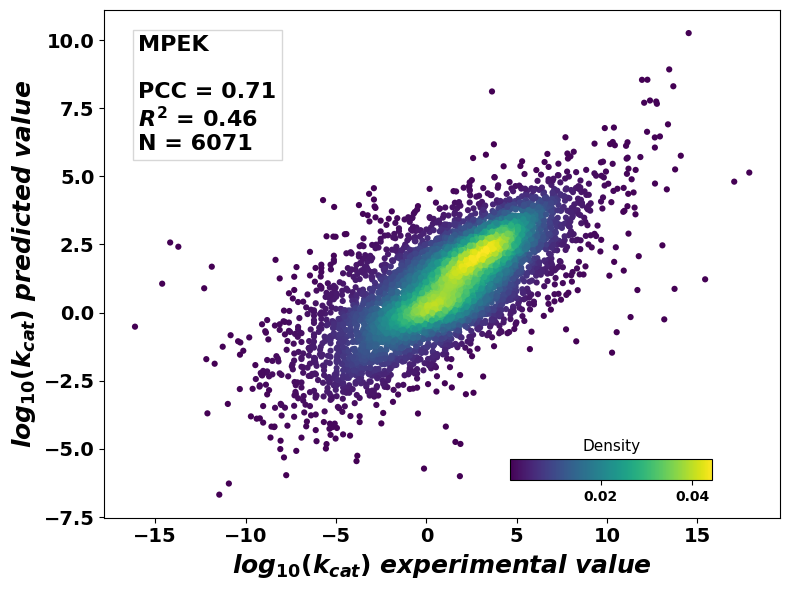

In [2]:

import matplotlib.pyplot as plt
from scipy.stats import pearsonr, gaussian_kde
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rc("font", weight="bold")

# 过滤掉填充值
mask = ~np.isnan(logkcat_test_y)
logkcat_test_y = logkcat_test_y[mask]
logkcat_pred_mean = logkcat_pred_mean[mask]
n = len(logkcat_test_y)

# 计算密度
xy = np.vstack([logkcat_test_y, logkcat_pred_mean])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots(figsize=(8, 6))

sc = ax.scatter(
    logkcat_test_y,
    logkcat_pred_mean,
    c=z,
    s=20,
    cmap='viridis',
    linewidths=0
)

# 在图内底部居中插入一个横向 colorbar
cax = inset_axes(
    ax,
    width="60%",        # 控制宽度百分比
    height="4%",        # 控制高度
    loc='lower center', # 放在图的内部底部中间
    bbox_to_anchor=(0.5, 0.02, 0.5, 1),  # 精细控制位置偏移（可选）
    bbox_transform=ax.transAxes,
    borderpad=2
)

cb = plt.colorbar(sc, cax=cax, orientation='horizontal')
cb.ax.tick_params(labelsize=10)
cb.set_label('Density', fontsize=11, labelpad=6)
cb.ax.xaxis.set_label_position('top')

ax.set_xlabel(r'$log_{10}(k_{cat})$ $experimental$ $value$', fontsize=18)
ax.set_ylabel(r'$log_{10}(k_{cat})$ $predicted$ $value$', fontsize=18)
ax.text(
    0.05, 0.95,
    f'MPEK\n\nPCC = {logkcat_scores[-1]:.2f}\n$R^2$ = {logkcat_scores[-2]:.2f}\nN = {n}',
    transform=ax.transAxes,
    bbox=dict(facecolor='white', edgecolor='lightgray', alpha=0.9),
    fontsize=16,
    verticalalignment='top'
)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid(False)
plt.tight_layout()

plt.savefig(f'{current_dir}/results/mpek_scatter.png')
plt.show()

# Check the data in folds

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import os
import numpy as np

random_state = 66
current_dir = os.getcwd()
df_input_path = current_dir + f'/../../data_process/dataset/df_standardized.pkl'
df_input = pd.read_pickle(df_input_path)
train_val_idx, test_idx = train_test_split(df_input.index, test_size=0.2, random_state=random_state)
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
for fold_idx, (train_index, val_index) in enumerate(kf.split(train_val_idx), start=1):
    fold_train_idx, fold_val_idx = train_val_idx[train_index], train_val_idx[val_index]
    break
df_input.loc[fold_train_idx].head(20)
print(f'Length of test dataset: {len(test_idx)}')

Length of test dataset: 9307
